# 목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를  생성하여 회귀분석을 실시하고 결과를 해석하라.(BMI 계산 시, WEIGHT는 파운드(1lb > 0.45kg), HEIGHT는 인치(1inch > 2.54cm)이므로 변환하여 사용)
# 데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

In [23]:
# 먼저 다중 회귀분석을 위해 필요한 라이브러리 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [24]:
# /home/pirl/Downloads/BigDataAnalysis 경로에 있는 체질검사.csv 파일을 파이썬으로 읽어옴
# csv는 몇 가지 필드를 쉼표(,)로 구분한 텍스트 데이터
df_raw=pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/체질검사.csv", engine="python")

# 데이터 파일의 앞부분을 출력(default = 5)
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [25]:
# 1. WEIGHT[lb] >> WEIGHT[kg] 변환 ; 1 lb = 0.45kg
# 2. HEIGHT[inch] >> HEIGHT[cm] 변환 ; 1 inch = 2.54cm

df_raw_converted = df_raw
df_raw_converted["WEIGHT"] = df_raw["WEIGHT"]*0.45
df_raw_converted["HEIGHT"] = df_raw["HEIGHT"]*2.54

# 각 열의 이름을 WEIGHT_kg, HEIGHT_cm로 바꿔줌
df_raw_converted.rename(columns={'WEIGHT': 'WEIGHT_kg', 'HEIGHT': 'HEIGHT_cm'}, inplace=True)
df_raw_converted.head()

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


 2018년 비만진료지침에서 단계별 용어가 새롭게 변경되어 18.5 미만이면 저체중, 18.5∼23은 정상, 23~25이면 '비만 전단계'[5], 25∼30은 '1단계 비만', 30∼35는 '2단계 비만' , 35 이상이면 '3단계 비만'으로 구분한다.

In [26]:
# BMI 계산해서 새로운 열 삽입
# BMI = WEIGHT / HEIGHT*HEIGHT (단, WEIGHT의 단위가 m이므로 10000을 곱해줘야 함)

df_raw_converted["BMI"] = df_raw_converted["WEIGHT_kg"] * 10000 / (df_raw_converted["HEIGHT_cm"]*df_raw_converted["HEIGHT_cm"])
df_raw_converted.head()

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


복부비만을 측정하는 신체계측지표로 허리둘레(Waist
circumference; WC), 허리/엉덩이 둘레비(Waist-to-hip ratio; WHR), 허리/신장비(Waist-to-height
ratio; WHtR)

In [27]:
# 허리/엉덩이 둘레비(Waist-to-hip ratio; WHR) 계산해서 새로운 열 삽입
# 허리/신장비(Waist-to-height ratio; WHtR) 계산해서 새로운 열 삽입

df_raw_converted["WHR"] = df_raw_converted["ABDOMEN"] / df_raw_converted["HIP"]
df_raw_converted["WHtR"] = df_raw_converted["ABDOMEN"] / df_raw_converted["HEIGHT_cm"]
df_raw_converted.head()

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI,WHR,WHtR
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870,1.002708,0.807018
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595,0.837037,0.437077
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478,0.966429,0.546008
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617,0.958935,0.517350
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165,1.082447,0.751107


In [28]:
#df_raw_converted의 count, mean, std, min....값을 소숫점 셋째자리까지 반올림해서 출력
df_raw_converted.describe().round(3)

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI,WHR,WHtR
count,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000
mean,19.151,44.885,80.516,178.178,37.992,100.824,92.556,99.905,59.406,38.590,23.102,32.273,28.664,18.230,25.737,0.925,0.522
std,8.369,12.602,13.225,9.304,2.431,8.430,10.783,7.164,5.250,2.412,1.695,3.021,2.021,0.934,9.483,0.059,0.081
min,0.000,22.000,53.325,74.930,31.100,79.300,69.400,85.000,47.200,33.000,19.100,24.800,21.000,15.800,17.875,0.788,0.397
25%,12.475,35.750,71.550,173.355,36.400,94.350,84.575,95.500,56.000,36.975,22.000,30.200,27.300,17.600,22.853,0.886,0.476
50%,19.200,43.000,79.425,177.800,38.000,99.650,90.950,99.300,59.000,38.500,22.800,32.050,28.700,18.300,24.896,0.920,0.514
75%,25.300,54.000,88.650,183.515,39.425,105.375,99.325,103.525,62.350,39.925,24.000,34.325,30.000,18.800,27.118,0.963,0.552
max,47.500,81.000,163.418,197.485,51.200,136.200,148.100,147.700,87.300,49.100,33.900,45.000,34.900,21.400,164.307,1.096,1.392


In [29]:
# 우선 종속변수인 FAT을 제거하여 나머지 변수들을 df_raw_x로 복사
# add_constant하여 상수값 포함
# df_vif를 생성하여 variable, VIF 열을 생성

df_raw_x = df_raw_converted.drop("FAT", axis=1)
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

#VIF 값을 기준으로 정렬하여 df_vif 출력
df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
10,ANKLE,1.935
12,FOREARM,2.230
1,AGE,2.254
13,WRIST,3.391
11,BICEPS,3.716
4,NECK,4.498
9,KNEE,5.043
8,THIGH,8.732
5,CHEST,10.830
3,HEIGHT_cm,118.387


In [30]:
#VIF 값이 10 이상이고, 가장 높은 WHtR를 제거하여 VIF 값을 다시 출력함

df_raw_x_const = df_raw_x_const.drop("WHtR", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
10,ANKLE,1.926
12,FOREARM,2.221
1,AGE,2.254
13,WRIST,3.389
11,BICEPS,3.707
4,NECK,4.498
9,KNEE,4.846
8,THIGH,8.650
14,BMI,9.099
5,CHEST,10.416


In [31]:
#VIF 값이 10 이상이고, 가장 높은 WHtR를 제거하여 ABDOMEN 값을 다시 출력함
df_raw_x_const = df_raw_x_const.drop("ABDOMEN", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
9,ANKLE,1.919
11,FOREARM,2.194
1,AGE,2.253
12,WRIST,3.371
14,WHR,3.615
10,BICEPS,3.661
4,NECK,4.454
8,KNEE,4.814
13,BMI,7.227
7,THIGH,8.061


In [32]:
#VIF 값이 10 이상이고,  가장 높은 WHtR를 제거하여 WEIGHT_kg 값을 다시 출력함
df_raw_x_const = df_raw_x_const.drop("WEIGHT_kg", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
8,ANKLE,1.848
10,FOREARM,2.193
1,AGE,2.211
11,WRIST,3.326
13,WHR,3.342
9,BICEPS,3.506
3,NECK,3.958
2,HEIGHT_cm,4.640
12,BMI,4.701
7,KNEE,4.789


In [33]:
# VIF 값이 모두 10 이하이므로, 더 이상 제거하지 않음
# 회귀 모델을 생성하여 결과값을 출력

reg_model = smf.ols(formula = "FAT ~ HEIGHT_cm + NECK + CHEST + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI + WHR", data=df_raw_converted)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     58.48
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.15e-64
Time:                        00:18:48   Log-Likelihood:                -719.80
No. Observations:                 252   AIC:                             1466.
Df Residuals:                     239   BIC:                             1511.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -73.3312      9.743     -7.527      0.0

In [34]:
# 후진제거법을 이용한 변수 선택 및 모델 생성
# 위의 결과에서 P-value > 0.05인 변수들은 FAT과 상관관계가 낮으므로 제거
# 그 결과 HEIGHT_cm + FOREARM + NECK + HIP + WRIST + WHR 변수들이 선정됨

reg_model = smf.ols(formula = "FAT ~ HEIGHT_cm + FOREARM + NECK + HIP + WRIST + WHR", data=df_raw_converted)
reg_result = reg_model.fit()
print(reg_result.summary())

# 이 때 Adj. R-squared: 0.735

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     117.0
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.99e-69
Time:                        00:18:49   Log-Likelihood:                -722.09
No. Observations:                 252   AIC:                             1458.
Df Residuals:                     245   BIC:                             1483.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -77.7200      7.237    -10.740      0.0

In [43]:
# 변수를 제거하는 기준은 알파 값, 속성 안에 포함(rfe.param)
df_raw_y = df_raw["FAT"]
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=6).fit(df_raw_x, df_raw_y)
selected_cols=df_raw_x.columns[rfe.support_]
removed_cols=df_raw_x.columns[~rfe.support_]

print("Selected Variables: {}".format(selected_cols))
print("Removed Variables: {}".format(removed_cols))

Selected Variables: Index(['NECK', 'HIP', 'FOREARM', 'WRIST', 'WHR', 'WHtR'], dtype='object')
Removed Variables: Index(['AGE', 'WEIGHT_kg', 'HEIGHT_cm', 'CHEST', 'ABDOMEN', 'THIGH', 'KNEE',
       'ANKLE', 'BICEPS', 'BMI'],
      dtype='object')


In [46]:
rfe_reg_model = smf.ols(formula = "FAT ~ HEIGHT_cm + FOREARM + NECK + HIP + WRIST + WHR", data=df_raw_converted)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     117.0
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.99e-69
Time:                        00:29:27   Log-Likelihood:                -722.09
No. Observations:                 252   AIC:                             1458.
Df Residuals:                     245   BIC:                             1483.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -77.7200      7.237    -10.740      0.0

In [44]:
# 후진제거법을 이용한 변수 선택 - 선택된 설명변수의 다중공선성 재진단
df_raw_x_rfe = df_raw_x[selected_cols]
df_raw_x_rfe_const = add_constant(df_raw_x_rfe)
#
df_rfe_vif = pd.DataFrame()
df_rfe_vif["variable"]=df_raw_x_rfe_const.columns
df_rfe_vif["VIF"]=[variance_inflation_factor(df_raw_x_rfe_const.values, i) for i in range(df_raw_x_rfe_const.shape[1])]
df_rfe_vif.sort_values("VIF", inplace = True)
df_rfe_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
3,FOREARM,1.766
5,WHR,1.978
6,WHtR,2.439
4,WRIST,2.493
2,HIP,3.338
1,NECK,3.611
0,const,516.042


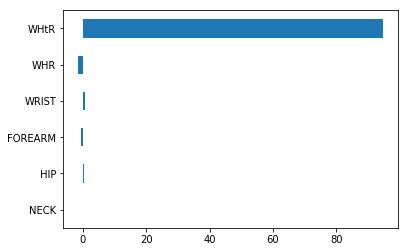

In [47]:
#위의 결과에서는 다중공선성 문제 없음

# 최종 모델의 회귀식 FAT = 516.042 + 1.766FOREARM + 1.978WHR + 2.439WHtR + 2.493WRIST + 3.338HIP + 3.611NECK

# 변수의 중요도 확인
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y="Coef", legend = False)


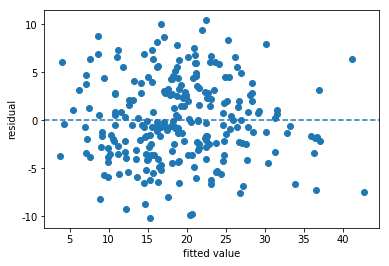

In [48]:
# 잔차 분석을 통해 잔차가 균일하게 분포함을 알 수 있음

plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y=0,linestyle="--")
mp.rcParams['axes.unicode_minus'] = False

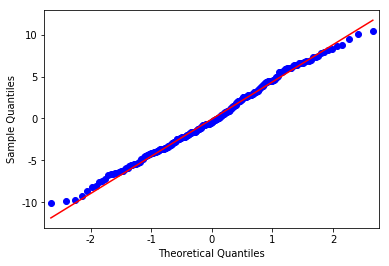

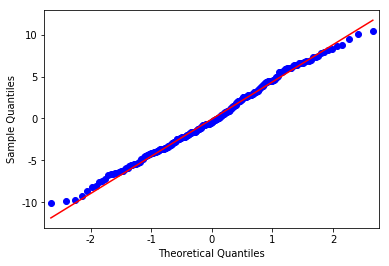

In [49]:
# 각 점들이 직선을 따라 분포하므로 오차항이 정규분포를 따른다고 할 수 있음
qqplot(reg_result.resid, line='q')